In [3]:
1.
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Methane_data = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
dataset = nc.Dataset(Methane_data, 'r')


C:\Users\lig\AppData\Local\Temp\ipykernel_16460\3601730480.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  xch4 = dataset.variables['xch4'][:]


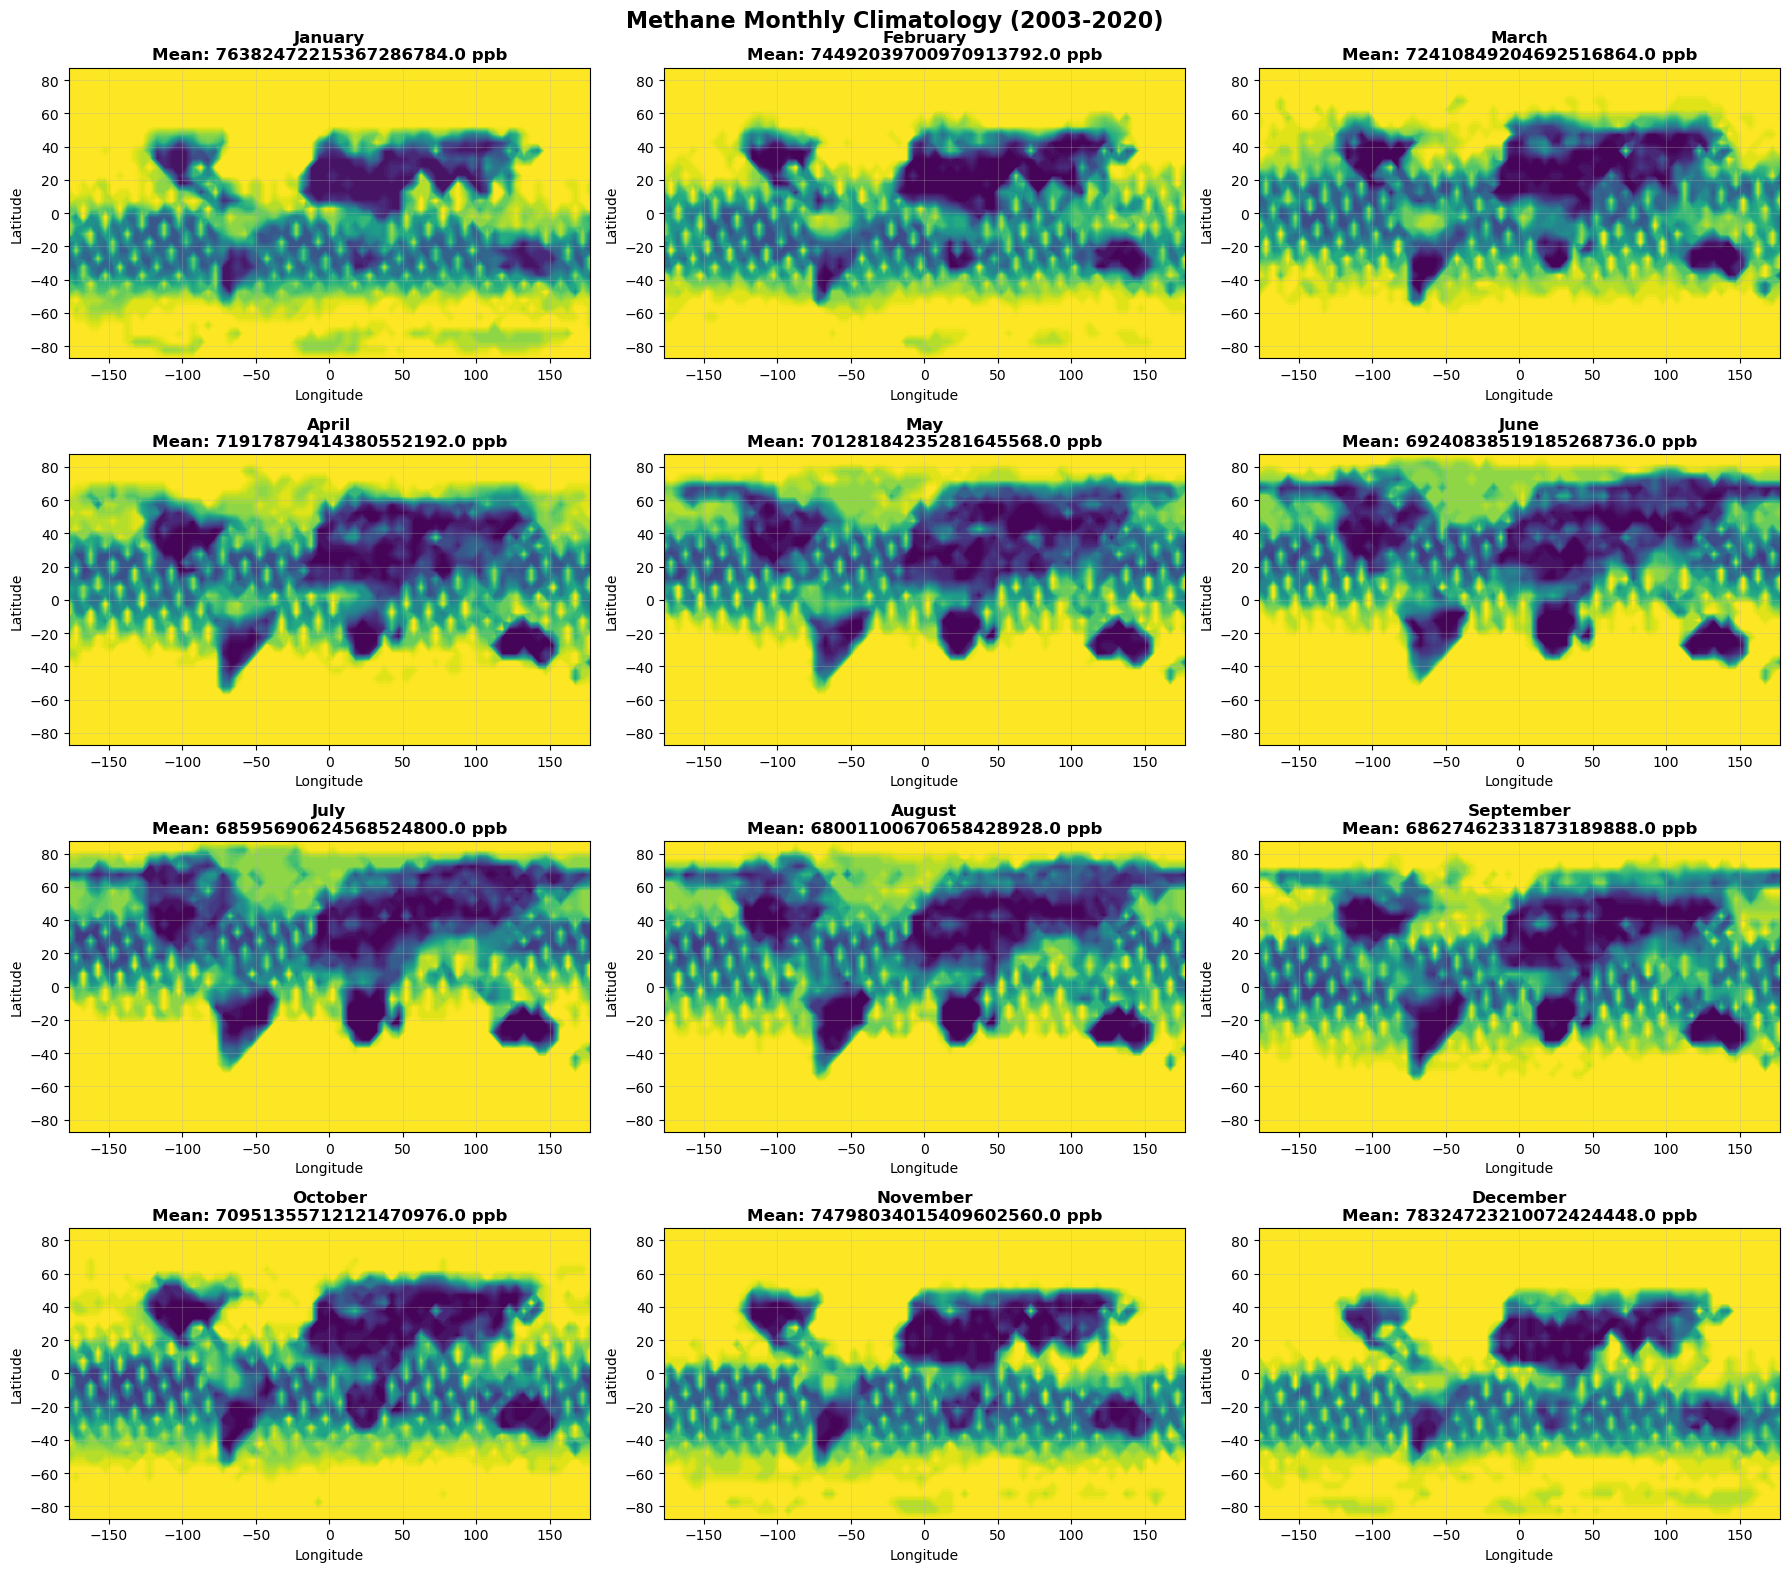

In [2]:
1.
def simple_monthly_climatology(file_path):
  
    # 读取数据
    dataset = nc.Dataset(file_path, 'r')
    xch4 = dataset.variables['xch4'][:]
    lon = dataset.variables['lon'][:]
    lat = dataset.variables['lat'][:]
    time = dataset.variables['time'][:]
    
    # 获取时间信息
    time_units = getattr(dataset.variables['time'], 'units', 'days since 2000-01-01')
    from netCDF4 import num2date
    dates = num2date(time, time_units)
    months = np.array([date.month for date in dates])
    
    # 计算每月气候态
    monthly_climatology = np.ma.zeros((12, len(lat), len(lon)))
    
    for month in range(1, 13):
        month_mask = months == month
        month_data = xch4[month_mask]
        if len(month_data) > 0:
            monthly_climatology[month-1] = np.ma.mean(month_data, axis=0)
    
    dataset.close()
    
    # 绘图
    month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    axes = axes.flatten()
    
    vmin = np.ma.min(monthly_climatology)
    vmax = np.ma.max(monthly_climatology)
    
    for month in range(12):
        data = monthly_climatology[month]
        im = axes[month].contourf(lon, lat, data, levels=50, cmap='viridis', 
                                 vmin=vmin, vmax=vmax)
        axes[month].set_title(f'{month_names[month]}\nMean: {np.ma.mean(data):.1f} ppb', 
                             fontweight='bold')
        axes[month].set_xlabel('Longitude')
        axes[month].set_ylabel('Latitude')
        axes[month].grid(True, alpha=0.3)
    
    plt.suptitle('Methane Monthly Climatology (2003-2020)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

simple_monthly_climatology("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc")

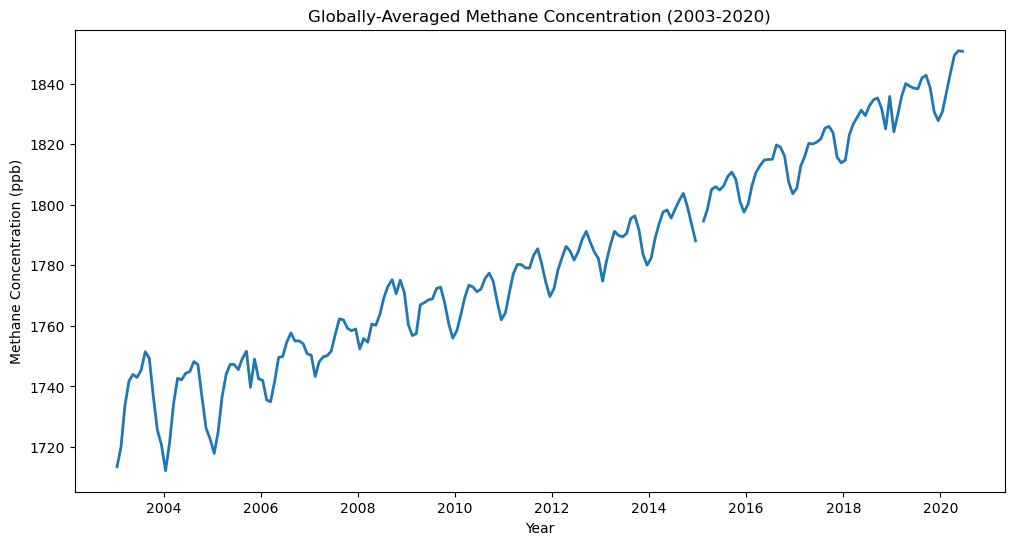

In [13]:
1.2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# 1. 读取数据
Methane_data = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
ds = xr.open_dataset(Methane_data)

# 2. 检查并强制处理缺失值
xch4 = ds['xch4']

# 检查 _FillValue 属性。通常它就是 1e20 附近
fill_value = xch4.encoding.get('_FillValue')
if fill_value is None:
    # 如果没有_FillValue，我们假设任何大于 1e19 的值都是无效数据
    fill_value = 1e20

# 强制将所有大于某个阈值的数值替换为 NaN
# 这是一个额外的安全措施，以防 xarray 自动解码失败
if fill_value > 1e19:
    xch4 = xch4.where(xch4 < 1e19) # 筛选掉异常大的数值

# 3. 单位转换 (从摩尔分数转为 ppb)
# 原始数据通常是 1e-6 级别 (摩尔分数)
mean_check = xch4.mean().item()
if mean_check < 1:
    xch4_ppb = xch4 * 1e9
else:
    xch4_ppb = xch4

# 4. 计算加权平均 (纬度加权)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# 使用 weighted().mean()。由于前面已经将缺失值转换为 NaN，这里可以安全地计算平均值
xch4_global = xch4_ppb.weighted(weights).mean(dim=("lat", "lon"))

# 5. 绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xch4_global.time, xch4_global, color='#1f77b4', linewidth=2, label='Global Mean XCH4')
plt.title('Globally-Averaged Methane Concentration (2003-2020)')
plt.ylabel('Methane Concentration (ppb)')
plt.xlabel('Year')
plt.show()

#结论：曲线整体呈现显著的上升趋势。其中2003-2006年期间增长相对缓慢，而从2007年开始，增长速率明显加快。在长期上升的趋势线上，叠加着锯齿状的季节性循环。这可能是由全球湿地排放、农业活动等的季节性变化引起的。

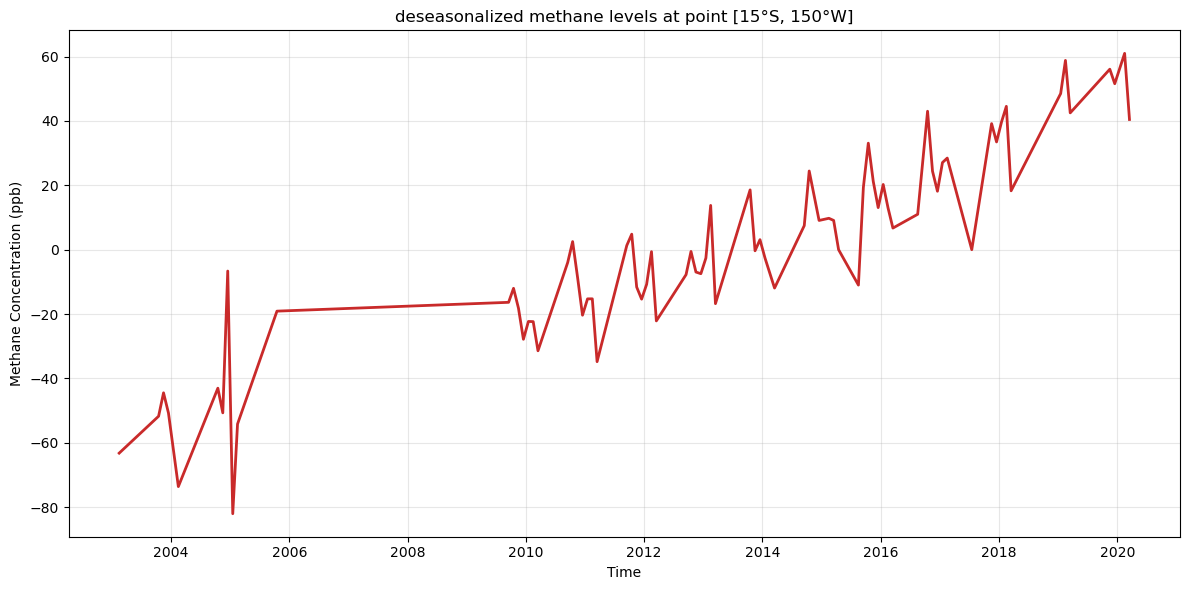

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 定义目标点并加载数据 
target_lat = -15.0  # 15°S
target_lon = -150.0 # 150°W
Methane_data = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
ds = xr.open_dataset(Methane_data)

# 选择距离目标经纬度最近的网格点
point_data = ds.sel(lat=target_lat, lon=target_lon, method='nearest')
xch4 = point_data['xch4']
selected_lat = point_data['lat'].item()
selected_lon = point_data['lon'].item()

# 清除缺失值，将其设为 NaN，确保只有小于物理有效范围的数值被保留
xch4 = xch4.where(xch4 < 1e19)

# 单位转换：从摩尔分数 转换为 ppb 
if xch4.mean().item() < 1:
    xch4_ppb = xch4 * 1e9
else:
    xch4_ppb = xch4

# 去季节化

# 计算气候平均值 ：每个月份的多年平均值
climatology = xch4_valid.groupby('time.month').mean(skipna=True)

# 从原始数据中减去气候平均值，得到去季节化后的时间序列
xch4_deseasonalized = xch4_valid.groupby('time.month') - climatology

# 绘图 
plt.figure(figsize=(12, 6))

# 绘制去季节化后的数据
xch4_deseasonalized.plot(label='De-seasonalized XCH4', color='#c92a2a', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Methane Concentration (ppb)')
plt.title(f'deseasonalized methane levels at point [15°S, 150°W]')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#结论：尽管曲线是去季节化的，但它仍将显示出清晰的长期上升趋势。说明全球甲烷排放量持续增加。

In [44]:
2.
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

SST_data = 'NOAA_NCDC_ERSST_v3b_SST.nc'
dataset = xr.open_dataset(SST_data)

# 查看数据结构
print(dataset)

<xarray.Dataset> Size: 44MB
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...


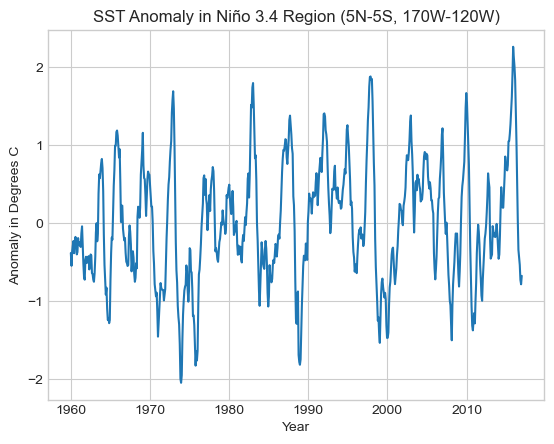

In [46]:
2.1
# 提取Niño 3.4区域的SST数据
# Niño 3.4 区域的经度范围：170W - 120W (对应为经度范围：170到240)
# Niño 3.4 区域的纬度范围：5N - 5S (对应为纬度范围：-5到5)

sst = dataset['sst']  # 假设sst是海表温度数据的变量名
lon = dataset['lon']
lat = dataset['lat']

# 提取Niño 3.4区域的SST数据
sst_nino34 = sst.sel(lon=slice(170, 240), lat=slice(-5, 5))

# 计算月度气候值
sst_monthly_climatology = sst_nino34.groupby('time.month').mean('time')

# 计算异常值
sst_climatology_expanded = sst_monthly_climatology.sel(month=sst_nino34['time.month'])

# 计算SST异常值
sst_anomalies = sst_nino34 - sst_climatology_expanded

# 绘图
sst_anomalies.mean('lat').mean('lon').plot()  # 计算并绘制Niño 3.4区域的SST异常值的时间序列
plt.title("SST Anomaly in Niño 3.4 Region (5N-5S, 170W-120W)")
plt.xlabel("Year")
plt.ylabel("Anomaly in Degrees C")
plt.show()

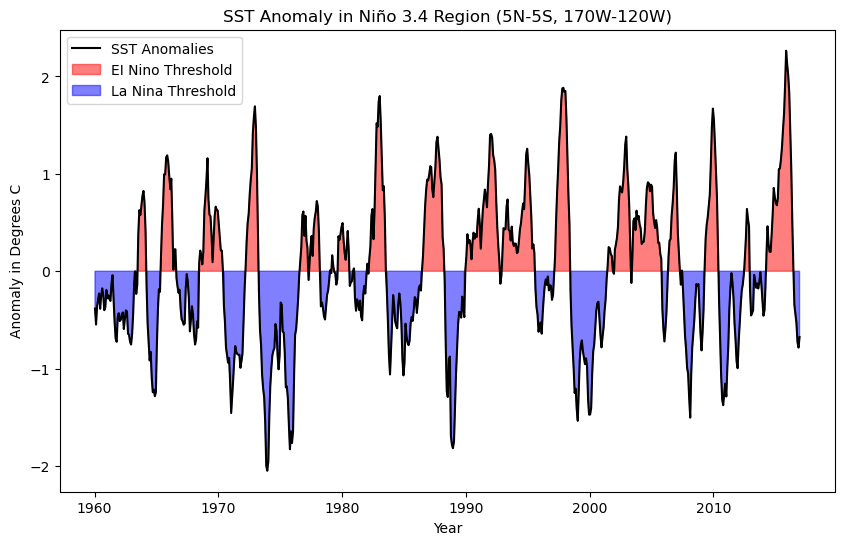

In [11]:
2.2
# 计算经纬度方向的均值，以得到时间序列
sst_anomalies_mean = sst_anomalies.mean('lat').mean('lon')

# 可视化：填充上方和下方的区域
plt.figure(figsize=(10, 6))
plt.plot(sst_anomalies_mean.time, sst_anomalies_mean, label="SST Anomalies", color="black")

# 填充上方区域为红色，低于0的部分为蓝色
plt.fill_between(sst_anomalies_mean.time, sst_anomalies_mean, 0,
                 where=(sst_anomalies_mean > 0), color='red', alpha=0.5, label="EI Nino Threshold")
plt.fill_between(sst_anomalies_mean.time, sst_anomalies_mean, 0,
                 where=(sst_anomalies_mean < 0), color='blue', alpha=0.5, label="La Nina Threshold")

# 添加标题和标签
plt.title("SST Anomaly in Niño 3.4 Region (5N-5S, 170W-120W)")
plt.xlabel("Year")
plt.ylabel("Anomaly in Degrees C")

# 显示图例
plt.legend()

# 显示图像
plt.show()

In [32]:
3
#合并文件
import xarray as xr

# 加载7个 netCDF 文件
file_2010 = 'CMS_Flux_Fire_2010_v2.nc'
file_2011 = 'CMS_Flux_Fire_2011_v2.nc'
file_2012 = 'CMS_Flux_Fire_2012_v2.nc'
file_2013 = 'CMS_Flux_Fire_2013_v2.nc'
file_2014 = 'CMS_Flux_Fire_2014_v2.nc'
file_2015 = 'CMS_Flux_Fire_2015_v2.nc'
file_2016 = 'CMS_Flux_Fire_2016_v2.nc'

# 打开文件
ds_2010 = xr.open_dataset(file_2010, decode_times=False)
ds_2011 = xr.open_dataset(file_2011, decode_times=False)
ds_2012 = xr.open_dataset(file_2012, decode_times=False)
ds_2013 = xr.open_dataset(file_2013, decode_times=False)
ds_2014 = xr.open_dataset(file_2014, decode_times=False)
ds_2015 = xr.open_dataset(file_2015, decode_times=False)
ds_2016 = xr.open_dataset(file_2016, decode_times=False)

#使用 concat 合并成一个文件
ds_combined = xr.concat([ds_2010, ds_2011, ds_2012, ds_2013, ds_2014, ds_2015, ds_2016], dim='time')

# 保存合并后的文件
ds_combined.to_netcdf('CMS_Flux_Fire_2010-2016_v2.nc')


In [15]:

# 打开NetCDF文件
data = 'CMS_Flux_Fire_2010-2016_v2.nc'
dataset = xr.open_dataset(data, decode_times=False)

# 查看数据结构
print(dataset)


<xarray.Dataset> Size: 6MB
Dimensions:           (time: 84, lat: 46, lon: 72)
Coordinates:
  * lat               (lat) float64 368B -89.0 -86.0 -82.0 ... 82.0 86.0 89.0
  * lon               (lon) float64 576B -180.0 -175.0 -170.0 ... 170.0 175.0
  * time              (time) float32 336B 0.0 1.0 2.0 3.0 ... 8.0 9.0 10.0 11.0
Data variables:
    area              (time, lat, lon) float32 1MB ...
    flux              (time, lat, lon) float64 2MB ...
    fluxunc           (time, lat, lon) float64 2MB ...
    seconds_in_month  (time) float32 336B ...
Attributes: (12/26)
    Format:                         NetCDF-4
    Conventions:                    CF-1.7
    ProductionDateTime:             2020-08-21T19:03:59Z
    RangeBeginningDate:             2010-01-01
    RangeBeginningTime:             00:00:00.0
    RangeEndingDate:                2011-01-01
    ...                             ...
    format:                         netCDF
    SouthernmostLatitude:           -90.0
    Westernmost

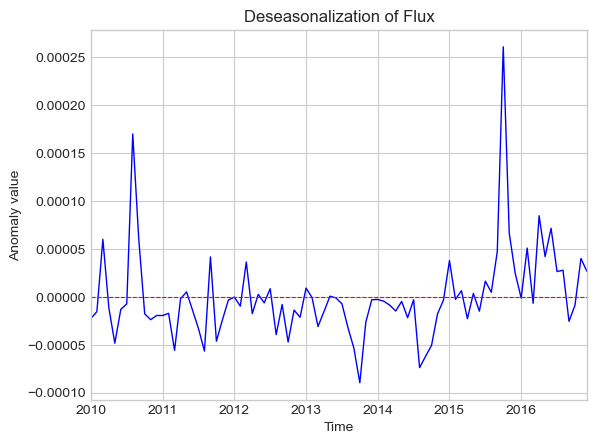

In [47]:
3.1
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 数据加载与时间修正 
file_path = "CMS_Flux_Fire_2010-2016_v2.nc"
variable_name = 'flux' # Flux为其中的一个变量

# 修正时间 (因为无法使用cftime)
ds = xr.open_dataset(file_path, decode_times=False)
time_values = ds['time'].values
new_time_index = pd.date_range(start='2010-01-01', periods=len(time_values), freq='MS')
ds['time'] = new_time_index

# 数据预处理 (空间平均) 

# 确定要平均的空间维度 (排除 time 维度)
dims_to_avg = [d for d in ds[variable_name].dims if d != 'time']

# 空间平均，生成时间序列 DataArray
ts_da = ds[variable_name].mean(dim=dims_to_avg, skipna=True).dropna(dim='time')

# 去除月度季节周期 

# 从原始时间序列中减去对应月份的气候平均值
anomaly = ts_da.groupby('time.month') - ts_da.groupby('time.month').mean(dim='time')

# 转换为 Series 方便绘图
anomaly_series = anomaly.to_series().dropna()

# 绘图 

anomaly_series.plot(
    title=f'Deseasonalization of Flux',
    xlabel='Time',
    ylabel='Anomaly value',
    linewidth=1.0,
    color='blue')

# 添加零线
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)

plt.show()

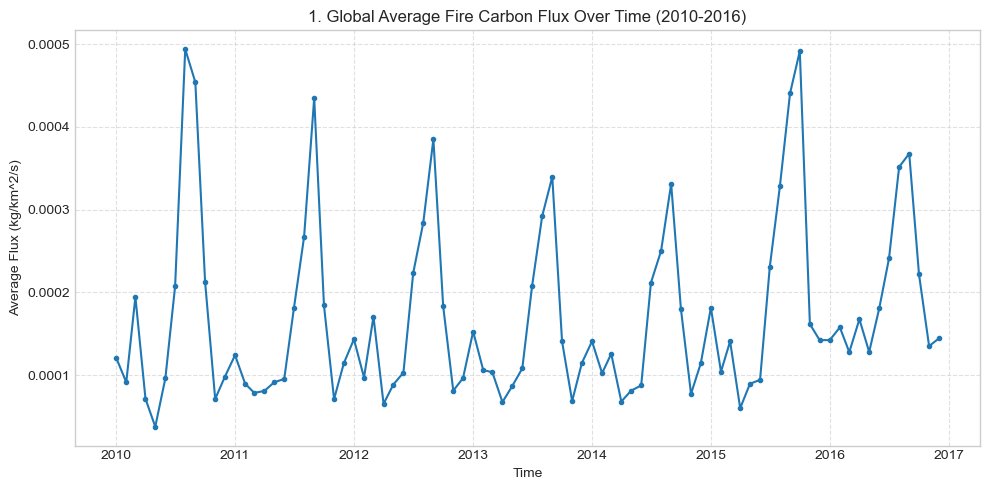

In [48]:
3.2

# 图1. 全球平均火灾碳通量时间序列图

# 计算全球平均值
global_mean_flux = flux.mean(dim=['lat', 'lon'])

# 绘图
plt.figure(figsize=(10, 5))
global_mean_flux.plot(marker='.', linestyle='-')
plt.title('1. Global Average Fire Carbon Flux Over Time (2010-2016)')
plt.ylabel(f"Average Flux ({flux_units})")
plt.xlabel("Time")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

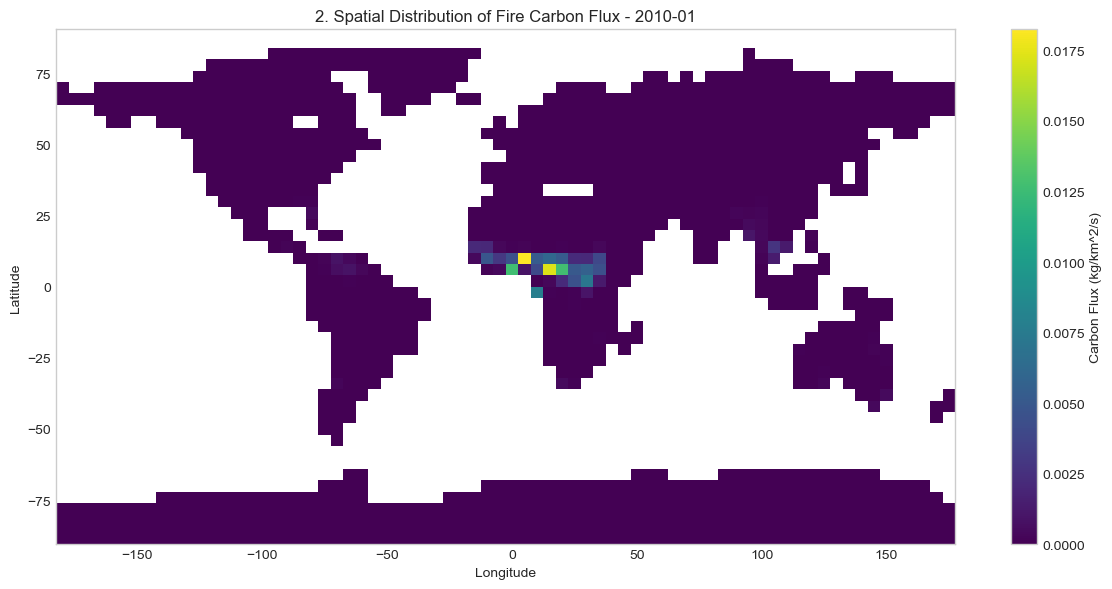

In [49]:
# 图2 2010年1月全球火灾碳通量空间分布图

# 选取第一个时间步长
first_month_flux = flux.isel(time=0)
time_label = pd.to_datetime(first_month_flux['time'].values).strftime('%Y-%m')

plt.figure(figsize=(12, 6))
# xarray 的 plot 绘图会自动识别经纬度
first_month_flux.plot(
    x='lon', y='lat', 
    cmap='viridis', 
    cbar_kwargs={'label': f"Carbon Flux ({flux_units})"}
)
plt.title(f'2. Spatial Distribution of Fire Carbon Flux - {time_label}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

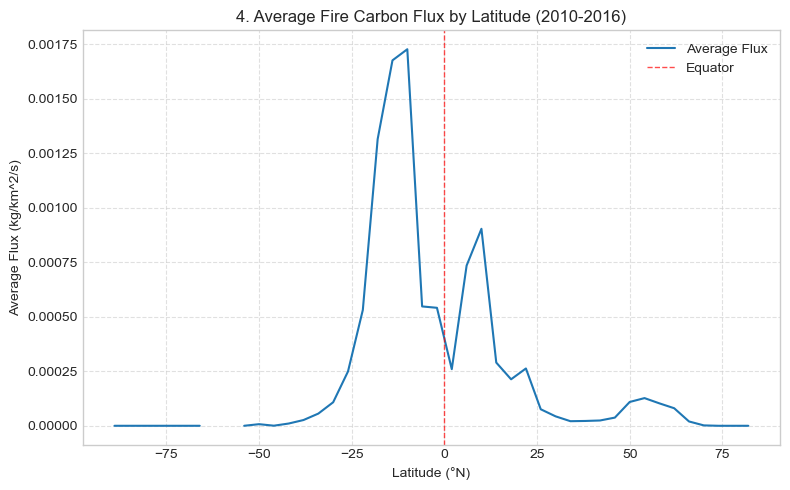

In [28]:
# 图3 火灾碳通量纬度剖面图
# 计算在 time 和 lon 维度上的平均值
lat_profile = flux.mean(dim=['time', 'lon'])

plt.figure(figsize=(8, 5))
lat_profile.plot(label='Average Flux')
# 标记赤道
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Equator')
plt.title('3. Average Fire Carbon Flux by Latitude (2010-2016)')
plt.ylabel(f"Average Flux ({flux_units})")
plt.xlabel("Latitude (°N)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

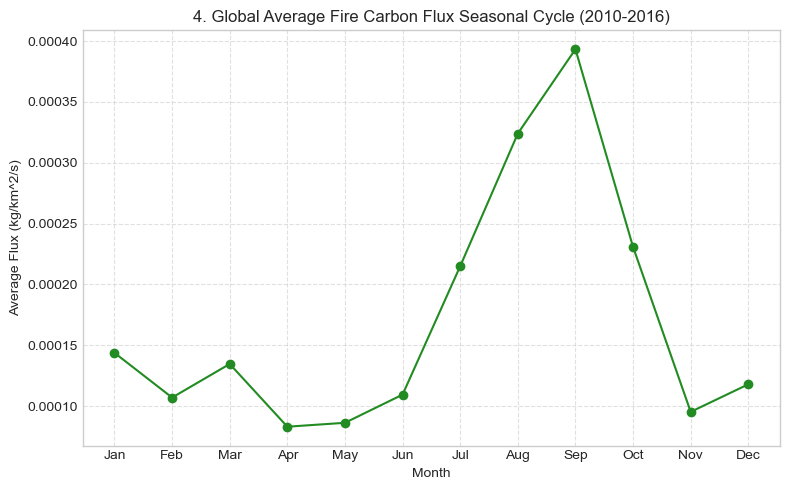

In [51]:
# 图表 4: 年平均季节性变化图 (Seasonal Cycle)

global_mean_flux = flux.mean(dim=['lat', 'lon'])

# 关键修复: 显式提取月份 DataArray 作为分组依据
month_da = global_mean_flux.time.dt.month
seasonal_cycle = global_mean_flux.groupby(month_da).mean()

plt.figure(figsize=(8, 5))
seasonal_cycle.plot(marker='o', linestyle='-', color='forestgreen')
plt.title('4. Global Average Fire Carbon Flux Seasonal Cycle (2010-2016)')
plt.ylabel(f"Average Flux ({flux_units})")
plt.xlabel("Month")
# 坐标轴标签修正为正确的月份名
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

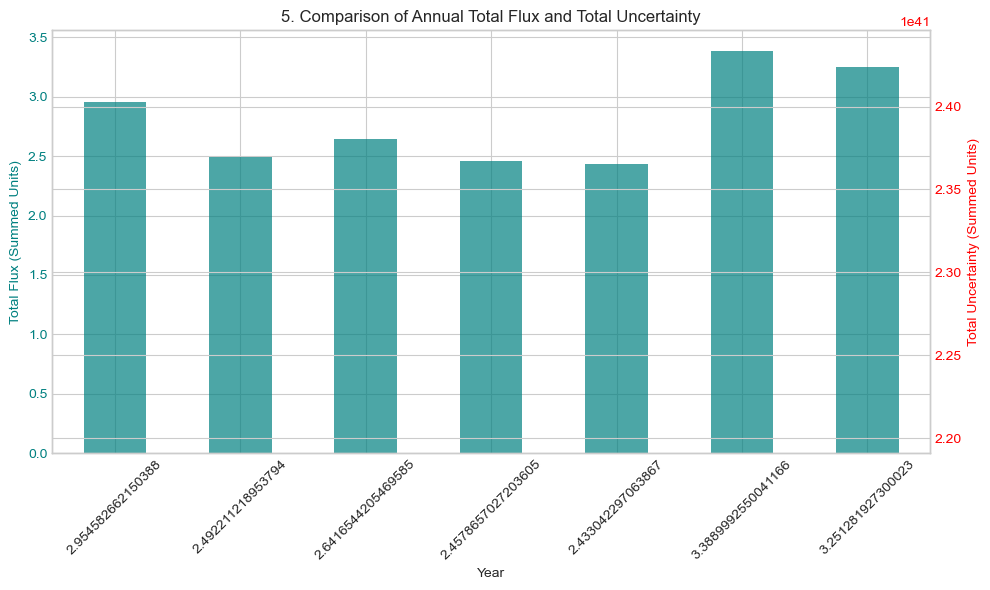

In [52]:
# 图 5: 年总通量和不确定性的对比图

global_monthly_sum_flux = flux.sum(dim=['lat', 'lon'])
global_monthly_sum_unc = fluxunc.sum(dim=['lat', 'lon'])

# 关键修复: 显式提取年份 DataArray 作为分组依据
year_da = global_monthly_sum_flux.time.dt.year

annual_sum_flux = global_monthly_sum_flux.groupby(year_da).sum()
annual_sum_unc = global_monthly_sum_unc.groupby(year_da).sum()

# 绘制双 Y 轴图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制通量 (柱状图)
# 由于分组后新的坐标名可能不是 'year' (而是 'year' 或 'group')，我们使用 to_series().plot.bar() 来保证标签正确
annual_sum_flux.to_series().plot.bar(ax=ax1, color='teal', alpha=0.7, label='Total Flux')
ax1.set_ylabel('Total Flux (Summed Units)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xlabel('Year')
ax1.set_title('5. Comparison of Annual Total Flux and Total Uncertainty')

# 绘制不确定性 (折线图)
ax2 = ax1.twinx()  # 创建第二个 Y 轴
annual_sum_unc.to_series().plot(ax=ax2, marker='o', linestyle='-', color='red', label='Total Uncertainty')
ax2.set_ylabel('Total Uncertainty (Summed Units)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 调整 X 轴标签
ax1.set_xticklabels(annual_sum_flux.values, rotation=45) # 使用 DataArray 的值作为标签
fig.tight_layout()
plt.show()